In [ ]:
import nltk
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [4]:
nltk.download('stopwords');

"""
Afegir stopwords contextuals
"""

nltk.download('movie_reviews');
from nltk.corpus import movie_reviews as mr;

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## Dividir en conjunt de test i train

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() # lowercase
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\n', ' ', text) # remove new lines
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation

    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatize the text and remove stop words
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in stop_words]

    return ' '.join(filtered_tokens) # return the text as string

In [6]:
fileids = mr.fileids()
categories = [mr.categories(fileid)[0] for fileid in fileids]  # 'pos' or 'neg'

data = pd.DataFrame({
    'text': [preprocess(mr.raw(fileid)) for fileid in fileids],   #Preprocess the text before creating the df
    'label': categories
})

# Split into train and test with stratify to balance categories
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

display(data.head())
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

,text,label
0,plot two teen couple go church party drink dri...,neg
1,happy bastard quick movie review damn yk bug g...,neg
2,movie like make jaded movie viewer thankful in...,neg
3,quest camelot warner bros first featurelength ...,neg
4,synopsis mentally unstable man undergoing psyc...,neg


Train size: 1600
Test size: 400


In [13]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train).astype(np.float32)
X_test_vectorized = vectorizer.transform(X_test).astype(np.float32)

## Inicialitzar els models seleccionats

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Definir modelos con random_state donde sea aplicable
random_state = 42
logr = LogisticRegression(random_state=random_state)  # Aumentar max_iter para convergencia
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=random_state)
lgbm = LGBMClassifier(random_state=random_state, verbose=-1)
svm = SVC(random_state=random_state)

# Definir los grids de hiperparámetros para cada modelo
logr_params = {
    'max_iter': [1000],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

lgbm_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31], 
}

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

In [ ]:
models = [
    ('Logistic Regression', logr, logr_params),
    ('KNN', knn, knn_params),
    ('Random Forest', rf, rf_params),
    ('LightGBM', lgbm, lgbm_params),
    ('SVM', svm, svm_params)
]

best_params = {}
best_scores = {}

for name, model, params in models:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=2)

    grid_search.fit(X_train_vectorized, y_train)

    best_params[name] = grid_search.best_params_
    best_scores[name] = grid_search.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [30]:
results_df = pd.DataFrame({
    'Model': list(best_scores.keys()),
    'Best Score': list(best_scores.values()),
    'Best Parameters': list(best_params.values())})

results_df = results_df.sort_values('Best Score', ascending=False)

display(results_df)

,Model,Best Score,Best Parameters
0,Logistic Regression,0.833750,"{'C': 0.1, 'max_iter': 1000, 'solver': 'liblin..."
2,Random Forest,0.833125,"{'max_depth': 20, 'max_features': 'sqrt', 'min..."
4,SVM,0.824375,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"
3,LightGBM,0.821875,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
1,KNN,0.575625,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei..."


## Evaluar els models en el test

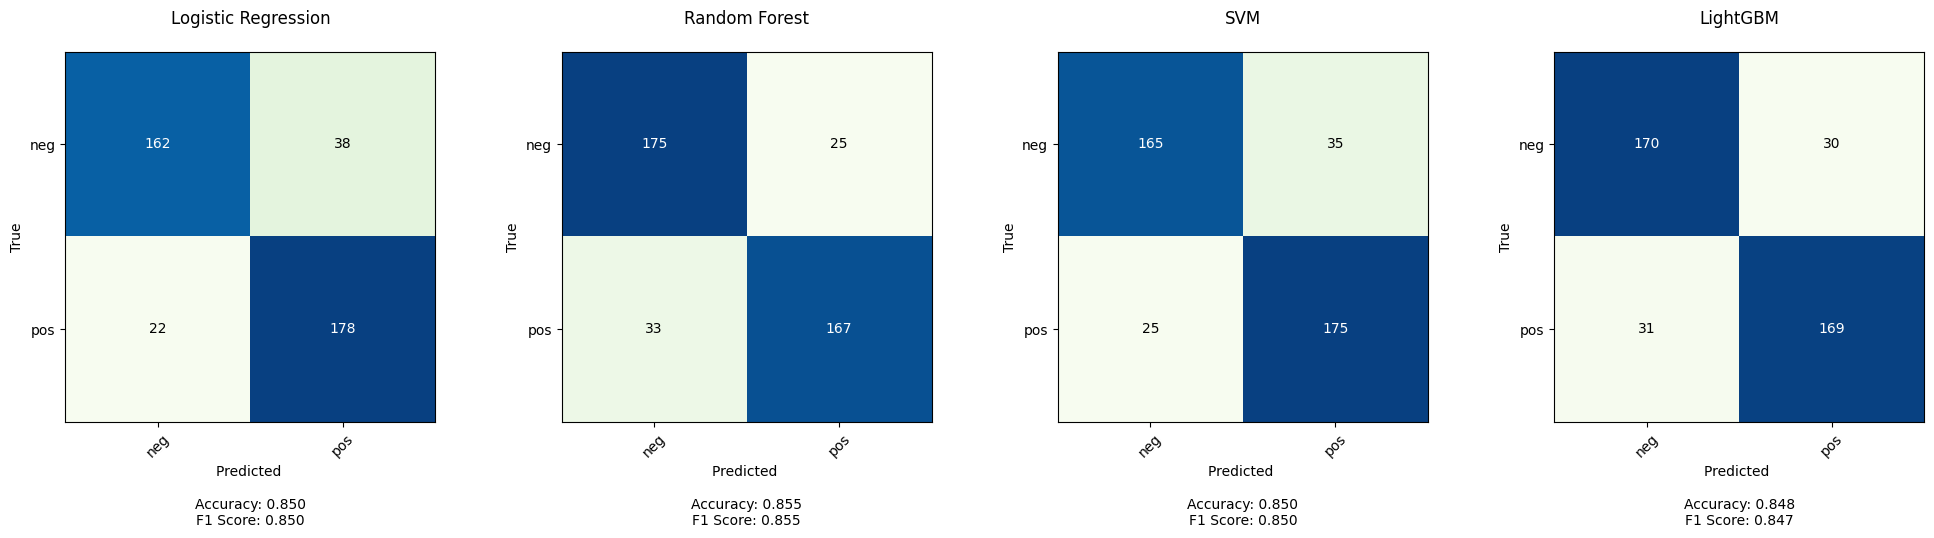

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

# Crear una figura grande con subplots en horizontal
results_filtered = results_df[results_df['Best Score'] > 0.7]
n_models = len(results_filtered) 
plt.figure(figsize=(5 * n_models, 5))  # Ancho ajustado al número de modelos

# Iterar por cada modelo
for idx, (index, row) in enumerate(results_filtered.iterrows(), 1):
    model_name = row['Model']
    model_params = best_params[model_name]

    # Instanciar modelo directamente desde la lista de modelos
    model = next(model for name, model, params in models if name == model_name)
    model.set_params(**model_params)

    # Entrenar y predecir (igual que tu código original)
    model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)
    
    # Calcular métricas
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Crear subplot en posición horizontal
    ax = plt.subplot(1, n_models, idx)  # 1 fila, N columnas, posición idx
    
    # Heatmap de matriz de confusión
    im = ax.imshow(conf_matrix, cmap='GnBu')
    
    # Configuraciones del plot
    ax.set_title(f"{model_name}", pad=20)
    ax.set_xticks(np.arange(len(set(y_test))), labels=set(y_test), rotation=45)
    ax.set_yticks(np.arange(len(set(y_test))), labels=set(y_test))
    ax.set_xlabel(f'Predicted \n\nAccuracy: {accuracy:.3f}\nF1 Score: {f1:.3f}')
    ax.set_ylabel('True')
    
    # Añadir texto en las celdas
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## Part no supervisada